In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()  # chọn OnlineRetail.csv từ máy bạn

# lấy tên file vừa upload (nếu upload 1 file)
fname = list(uploaded.keys())[0]
print("Uploaded file:", fname)

# đọc file (thử encoding latin1 vì file này thường có ký tự đặc biệt)
df = pd.read_csv(io.BytesIO(uploaded[fname]), encoding='latin1')
print("Kích thước dataframe:", df.shape)
df.head()


Saving OnlineRetail.csv to OnlineRetail.csv
Uploaded file: OnlineRetail.csv
Kích thước dataframe: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


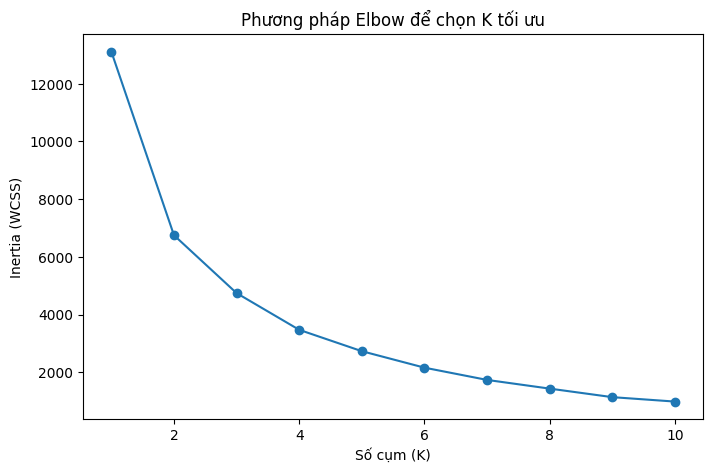


Đặc trưng trung bình của từng cụm:
         Frequency  TotalQuantity       Monetary
Cluster                                         
0         3.243841     562.685772     921.860531
1        75.136364   31949.818182   47483.389091
2        19.523161    4036.337875    7107.799210
3        93.600000   96858.400000  195941.550000


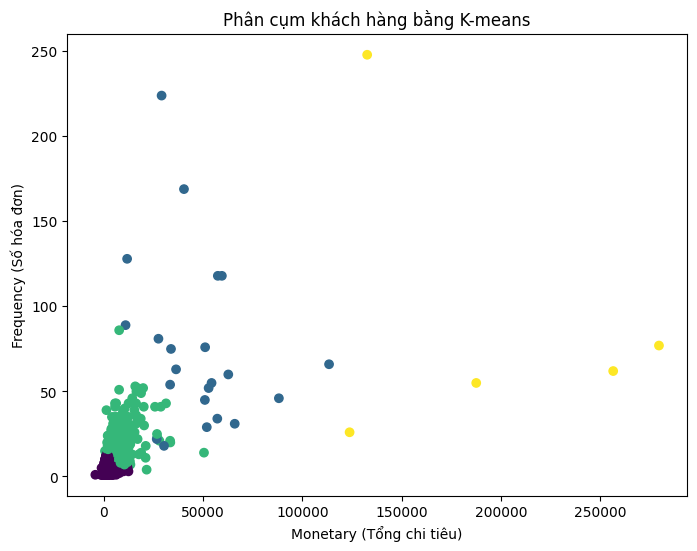

In [ ]:
# Gán lại tên biến cho thống nhất
data = df.copy()

# ===============================
# PHÂN CỤM KHÁCH HÀNG - K-MEANS
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1️⃣ Tiền xử lý dữ liệu
data = data.dropna(subset=['CustomerID'])  # loại bỏ dòng thiếu CustomerID
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']  # tổng giá trị hóa đơn

# 2️⃣ Tính đặc trưng RFM (Frequency, Quantity, Monetary)
rfm = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',      # số hóa đơn
    'Quantity': 'sum',           # tổng sản phẩm mua
    'TotalPrice': 'sum'          # tổng chi tiêu
}).reset_index()

rfm.rename(columns={'InvoiceNo': 'Frequency',
                    'Quantity': 'TotalQuantity',
                    'TotalPrice': 'Monetary'}, inplace=True)

# 3️⃣ Chuẩn hóa dữ liệu
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Frequency', 'TotalQuantity', 'Monetary']])

# 4️⃣ Elbow Method chọn K tối ưu
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'o-')
plt.xlabel("Số cụm (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Phương pháp Elbow để chọn K tối ưu")
plt.show()

# 5️⃣ Huấn luyện mô hình K-means với K=4 (ví dụ)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 6️⃣ Tóm tắt kết quả
cluster_summary = rfm.groupby('Cluster')[['Frequency', 'TotalQuantity', 'Monetary']].mean()
print("\nĐặc trưng trung bình của từng cụm:")
print(cluster_summary)

# 7️⃣ Biểu đồ minh họa
plt.figure(figsize=(8,6))
plt.scatter(rfm['Monetary'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis')
plt.xlabel("Monetary (Tổng chi tiêu)")
plt.ylabel("Frequency (Số hóa đơn)")
plt.title("Phân cụm khách hàng bằng K-means")
plt.show()
